This notebook is about building a CIFAR - 10 Object Recognition using ResNet50 with Transfer Learning. Here we used the pre-trained model called ResNet50 for Object Recognition. Transfer Learning is an important concept in Deep Learning.


All the 60000 images belong to 10 categories.(airoplane, automobile, bird, cat etc). It is basically image recognition model. We have to use a convolutional base model(CNN: as built for image recognition)

We will train basic neural network from the data, and later we will use ResNet50 model, a pretrained convolutional neural network model. That pretrained model with CIFAR dataset

Runtime type change to GPU kr lo

In [62]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available.")

# After setting runtime to T4 vala colab me


Default GPU Device: /device:GPU:0


In [63]:
!pip install kaggle

In [64]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [65]:
# dataset loading via api
!kaggle competitions download -c cifar-10

cifar-10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [66]:
!ls
# Canadian Institute for Advanced Research = CIFAR

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


In [67]:
# extracting the compressed datase
from zipfile import ZipFile
dataset = '/content/cifar-10.zip'

with ZipFile(dataset,'r') as zip: # reading as zip and then extraction
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [68]:
!ls # all commands similar to linux just ! aage add krna hota hai

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


In [69]:
# for extraction 7z files
!pip install py7zr

In [70]:
import py7zr

archive = py7zr.SevenZipFile('/content/train.7z', mode='r') # training data extraction
archive.extractall() #archive.extractall(path='/content/Training Data') : within paranthesis specify a path if you want to extract withig some specific folder
archive.close()

In [71]:
!ls

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


Import the dependencies

In [72]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [73]:
filenames = os.listdir('/content/train')

In [74]:
type(filenames)

list

In [75]:
len(filenames) # 50000 training data/images

50000

In [76]:
print(filenames[0:5]) # first 5 images fielss names
print(filenames[-5:]) # last 5 file names
# clearly names are in form : id.png

['39919.png', '14670.png', '20011.png', '49214.png', '25186.png']
['49695.png', '28799.png', '29641.png', '28455.png', '22271.png']


Labels Processing : labels are given in traincsv separate file

In [77]:
labels_df = pd.read_csv('/content/trainLabels.csv')

In [78]:
labels_df.shape

(50000, 2)

In [79]:
labels_df.head() # good id, label is given

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [80]:
labels_df[labels_df['id']==7796]

,id,label
7795,7796,frog


In [81]:
labels_df[labels_df['id']==44444]

,id,label
44443,44444,airplane


In [82]:
# images are not in order in train directory, but here labels me they are properly ordered

In [83]:
# reading the images in order : also numerical encoding for labels.

# some confirmations

In [84]:
labels_df['label'].value_counts()
# clearly distribution is even and random

frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: label, dtype: int64

In [85]:
labels_df['label']

0              frog
1             truck
2             truck
3              deer
4        automobile
            ...    
49995          bird
49996          frog
49997         truck
49998    automobile
49999    automobile
Name: label, Length: 50000, dtype: object

In [86]:
# let's do manually , taki hme pta rhe kon sa label kisse belong krta hai. Also doing alphabetically
labels_dictionary = {'airplane':0,
                     'automobile':1,
                     'bird':2,
                     'cat':3,
                     'deer':4,
                      'dog':5,
                     'frog':6,
                     'horse':7,
                     'ship':8,
                     'truck':9
                     }

labels = [labels_dictionary[i] for i in labels_df['label']] # label_df me label column ki values ko dictionary ki keys bana rhe hain
# and labels = , se labels ko us key ke corresponding values se replace mar rhe hain and ek nye list label me store kr kre numerical labels ko, jo 1,2,3,.. order me given images ko 1,2,3.. ke rder me hi unka label store krte hain

In [87]:
print(labels[0:5]) # fist 5 labels
print(labels[-5:]) # last 5 labels
# remember labels are in ordeer of id, 1 to 50000, index ke basis pr 0 to 49999.
# but labels are in order of id, as trainlabels.csv me increasing order me ids lgi thi, rows me

[6, 9, 9, 4, 1]
[2, 6, 9, 1, 1]


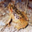

In [88]:
# image are really small 32*32 pixels

# displaying the sample image

import cv2
# cv2.imshow() won't work in google colab, since that function creates a window and this colab is not suitable to create a window
# hence colab provide alternate function, use it
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/train/7796.png')
cv2_imshow(img) # seems like frog, very small

In [89]:
# check
labels_df[labels_df['id']==7796]

,id,label
7795,7796,frog


In [90]:
# train folder me images are not in order

In [91]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   label   50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [92]:
id_list = list(labels_df['id']) # id ki list bana rhe that's it

In [93]:
print(id_list[0:5])
print(id_list[-5:])

[1, 2, 3, 4, 5]
[49996, 49997, 49998, 49999, 50000]


# Image Processing

In [94]:
# convert image to numpy arrays

train_data_folder = '/content/train/' # make sure to inpude forward slash copy krke paste krne pr

data=[] # empth list

for id in id_list:
  image = Image.open(train_data_folder+str(id)+'.png') # like /content/train/444.png ; full path with file name, will be opened
  image = np.array(image)
  data.append(image)

In [95]:
type(data) # list of arrays, clear by the below line of code

list

In [96]:
type(data[0])

numpy.ndarray

In [97]:
# what is the shape of each numpy array
data[0].shape # 32*32 ke 3, 2D arrays. = each image is rgb image

(32, 32, 3)

In [98]:
data[0]
# all the values ranges between 0 to 255 : so all the images are in numpy array

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [99]:
# convert image_list and label list to numpy array

X = np.array(data)
Y = np.array(labels)

In [100]:
type(X)

numpy.ndarray

In [101]:
print(X.shape)
print(Y.shape)

(50000, 32, 32, 3)
(50000,)


train test split

In [102]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 2)

In [103]:
print(X.shape,x_train.shape, x_test.shape)

(50000, 32, 32, 3) (40000, 32, 32, 3) (10000, 32, 32, 3)


In [104]:
# scalling the data
x_train_scaled = x_train/255
x_test_scaled = x_test/255
# in most cases it increases the performance of the neural network
# this kind of things can be done with np array only, not with lists

In [105]:
x_train_scaled

array([[[[0.81960784, 0.82352941, 0.79607843],
         [0.83529412, 0.83921569, 0.81960784],
         [0.85490196, 0.85882353, 0.84313725],
         ...,
         [0.49803922, 0.29019608, 0.15294118],
         [0.47843137, 0.26666667, 0.1372549 ],
         [0.45490196, 0.24705882, 0.1254902 ]],

        [[0.82352941, 0.82352941, 0.79215686],
         [0.83529412, 0.83921569, 0.81176471],
         [0.85490196, 0.8627451 , 0.83921569],
         ...,
         [0.48627451, 0.2745098 , 0.1372549 ],
         [0.4745098 , 0.2627451 , 0.12941176],
         [0.48235294, 0.27058824, 0.14117647]],

        [[0.80784314, 0.80392157, 0.76470588],
         [0.81960784, 0.81960784, 0.79215686],
         [0.83529412, 0.84313725, 0.81960784],
         ...,
         [0.48627451, 0.2745098 , 0.14509804],
         [0.51372549, 0.30196078, 0.16470588],
         [0.51372549, 0.30588235, 0.16078431]],

        ...,

        [[0.49803922, 0.42352941, 0.38039216],
         [0.54117647, 0.47843137, 0.43137255]

In [106]:
x_train[0] # one single image.

array([[[209, 210, 203],
        [213, 214, 209],
        [218, 219, 215],
        ...,
        [127,  74,  39],
        [122,  68,  35],
        [116,  63,  32]],

       [[210, 210, 202],
        [213, 214, 207],
        [218, 220, 214],
        ...,
        [124,  70,  35],
        [121,  67,  33],
        [123,  69,  36]],

       [[206, 205, 195],
        [209, 209, 202],
        [213, 215, 209],
        ...,
        [124,  70,  37],
        [131,  77,  42],
        [131,  78,  41]],

       ...,

       [[127, 108,  97],
        [138, 122, 110],
        [141, 127, 118],
        ...,
        [158, 149, 134],
        [161, 156, 151],
        [136, 137, 148]],

       [[145, 130, 119],
        [148, 135, 128],
        [136, 127, 128],
        ...,
        [175, 174, 172],
        [160, 161, 170],
        [143, 148, 164]],

       [[138, 128, 123],
        [140, 132, 136],
        [136, 131, 140],
        ...,
        [150, 154, 169],
        [145, 149, 166],
        [140, 145, 163]]

# Building the neural network

In [107]:
import tensorflow as tf
from tensorflow import keras

In [108]:
num_of_classes = 10

# seting the layers of neural network

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,32,3)), # input layer
    keras.layers.Dense(64,activation='relu'), # 1 hidden layer with 64 neurons: power of 2 me use kro neurons ko
    keras.layers.Dense(num_of_classes,activation='softmax') #output layer
])

#  power of 2 me use kro neurons ko : since computatioanally efficient hai : ram gpu etc me beeter combination bnta hai, 2^ me neurons rkhne pr

In the code you provided, you are defining a neural network model using Keras. The layers in the model are as follows:

1. Input Layer:
   - `keras.layers.Flatten(input_shape=(32, 32, 3))`
   - This is the input layer, and it is responsible for flattening the input data. In this case, the input shape is (32, 32, 3), which typically corresponds to a 32x32 pixel RGB image. It converts this 3D input into a 1D array of 32x32x3 = 3072 input neurons.

2. Hidden Layer:
   - `keras.layers.Dense(64, activation='relu')`
   - This is a hidden layer with 64 neurons and a ReLU activation function. It's where the actual computation happens. The ReLU (Rectified Linear Unit) activation is applied to the output of this layer.

3. Output Layer:
   - `keras.layers.Dense(num_of_classes, activation='softmax')`
   - This is the output layer with the number of neurons equal to `num_of_classes`, which is set to 10 in your code. The 'softmax' activation function is commonly used in the output layer for multi-class classification problems. It produces probabilities for each class, and the class with the highest probability is the predicted class.

So, in summary:
- Input Layer: The Flatten layer, which processes the input data.
- Hidden Layer: The Dense layer with 64 neurons and ReLU activation.
- Output Layer: The Dense layer with a number of neurons equal to the number of classes (10 in this case) and a softmax activation, making it suitable for classification tasks.

These layers together form a simple feedforward neural network architecture.

In [109]:
# compile the neural network
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy', # label encoding, on hot me catogorical crossentropy
              metrics = ['acc']
              )

In [110]:
# training the neural network
model.fit(x_train_scaled, y_train, validation_split=0.1,epochs=10) # model will go through data 10 times, each epochs me model will keep 10% data as test data, and 90% as training data and update parameters

Epoch 1/10
1125/1125 [==============================] - 7s 5ms/step - loss: 2.0692 - acc: 0.2202 - val_loss: 1.8781 - val_acc: 0.2993
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.8943 - acc: 0.2956 - val_loss: 1.8583 - val_acc: 0.3088
Epoch 3/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.8641 - acc: 0.3139 - val_loss: 1.8790 - val_acc: 0.2887
Epoch 4/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.8517 - acc: 0.3230 - val_loss: 1.8689 - val_acc: 0.3103
Epoch 5/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.8390 - acc: 0.3277 - val_loss: 1.8178 - val_acc: 0.3315
Epoch 6/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.8320 - acc: 0.3310 - val_loss: 1.8127 - val_acc: 0.3363
Epoch 7/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.8232 - acc: 0.3340 - val_loss: 1.8732 - val_acc: 0.3070
Epoch 8/10
1125/1125 [==============================] - 3s 3ms

In [111]:
# even after 10 epochs , only 40 % accuracy
# hence use pretrained model, train that on top of our own custom dataset,
# those datasets would achieve better performance on small number of epochs

Certainly, let me explain the sentences more clearly:

1. In the first sentence, "Even after 10 epochs, the model we trained and created achieved only 40% accuracy," it means that despite training a model for 10 complete cycles through the dataset, the model's accuracy on the task was only 40%. This indicates that the model's performance was not satisfactory.

2. In the second sentence, "Therefore, we should utilize a pre-trained model, and fine-tune it on top of our custom dataset," it suggests that a better approach would be to use a pre-trained model. A pre-trained model is a neural network that has already been trained on a large dataset for a different but related task. We can take this model and fine-tune it by training it on our own custom dataset. Fine-tuning means adapting the pre-trained model's weights and parameters to perform well on our specific task.

3. In the third sentence, "This approach is expected to yield better performance with just a small number of epochs, thanks to the benefits of transfer learning," it means that by using a pre-trained model and fine-tuning it on our dataset, we anticipate achieving better performance in terms of accuracy and other metrics. Additionally, because we are starting with a well-trained model, we may not need to train it for as many epochs (complete cycles through the dataset) as we would with a model trained from scratch. This is because the pre-trained model has already learned useful features and patterns from its previous training, which can be leveraged for our specific task. This approach is known as transfer learning, where knowledge gained from one task is transferred to another related task.

ResNet50

In [112]:
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [113]:
convolutional_base = ResNet50(weights = 'imagenet',include_top=False,input_shape=(256,256,3))

# resnet50 model is trained on imagenet data, and have retained those weights. It has approx 1000 classses
# weights = imagenet : these are weights derived from training of resnet50 model

# include_top = False => [imagenet me 1000 classes => ideally output layer me bhi 1000 nodes/neurons honge]
# here we have just 10 classes, not the all. so include top= false, will just import resnot50 model , but drop the output layer
# we will add custom output layer with 10 nodes/neurons.

# 256*256 pixels ki rgb images : resnet50 ke dvara li jati hain, but ye 32*32 nhi hain
# lets resolve 32*32 and 256*256 problem

convolutional_base.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [116]:
num_of_classes=10
# adding our own layers to this convolutional base
model = models.Sequential()
model.add(layers.UpSampling2D((2,2))) # h*2, w*2
model.add(layers.UpSampling2D((2,2))) # h*2, w*2
model.add(layers.UpSampling2D((2,2))) # h*2, w*2  since 32*2*2*2=256
model.add(convolutional_base)
model.add(layers.Flatten()) # matric into vector : single dimentsion : input layer
model.add(layers.BatchNormalization()) # just make sure all the values are in same range. Scale phle kr diye ho to, batchnormalization() krne ki jarurat nhi hai, but the processed values may not be normalized. So after each layer we will do batch normalization
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5)) # NN are complex models, have tendency to overfit. some set of neurons will be turned off to 0, to avoid the risk of overfitting
model.add(layers.BatchNormalization())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization()) # so 2 hidden layers, 1 input, 1 output
model.add(layers.Dense(num_of_classes,activation='softmax')) # output layer
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

In [121]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss="sparse_categorical_crossentropy",
              metrics = ['accuracy']
              )

In [122]:
history = model.fit(x_train_scaled, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
1125/1125 [==============================] - 482s 395ms/step - loss: 10.6096 - accuracy: 0.1504 - val_loss: 4.3798 - val_accuracy: 0.4460
Epoch 2/10
1125/1125 [==============================] - 445s 395ms/step - loss: 9.3504 - accuracy: 0.2204 - val_loss: 3.2067 - val_accuracy: 0.5470
Epoch 3/10
1125/1125 [==============================] - 445s 396ms/step - loss: 8.6740 - accuracy: 0.2601 - val_loss: 2.8105 - val_accuracy: 0.6162
Epoch 4/10
1125/1125 [==============================] - 442s 393ms/step - loss: 8.3385 - accuracy: 0.2772 - val_loss: 2.4716 - val_accuracy: 0.6597
Epoch 5/10
1125/1125 [==============================] - 442s 393ms/step - loss: 7.9024 - accuracy: 0.3036 - val_loss: 2.3371 - val_accuracy: 0.6930
Epoch 6/10
1125/1125 [==============================] - 441s 392ms/step - loss: 7.6572 - accuracy: 0.3123 - val_loss: 2.2517 - val_accuracy: 0.7197
Epoch 7/10
1125/1125 [==============================] - 448s 398ms/step - loss: 7.2953 - accuracy: 0.3299 - val

Finally 76% accuracy 46% se badhte badhte, epochs badhakr accuracy aur bdha skte ho

In [123]:
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print('Test Accuracy ',accuracy)

313/313 [==============================] - 37s 111ms/step - loss: 2.1868 - accuracy: 0.7493
Test Accuracy  0.7493000030517578


Not much change = model is not overfitted

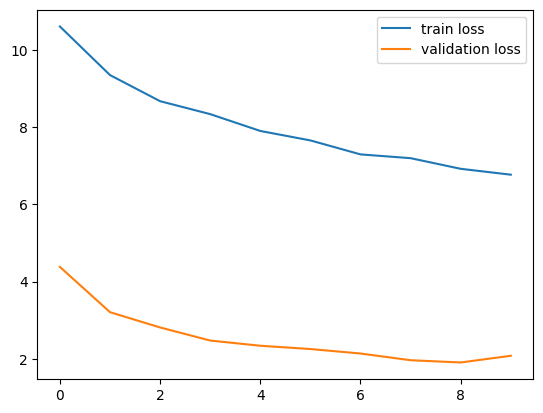

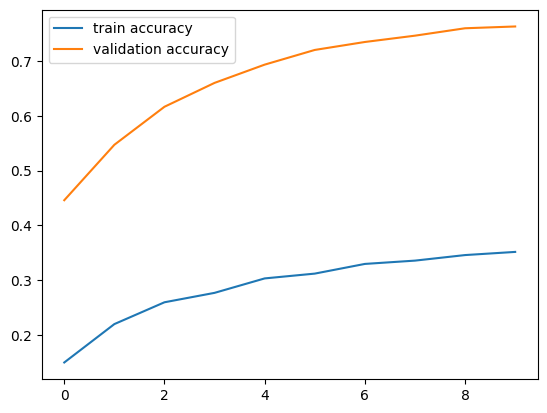

In [126]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

Building a predictive system

Path of the image to be predicted: /content/images.png


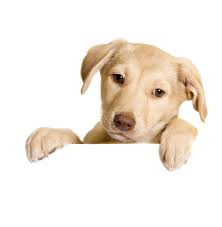

(1, 256, 256, 3)


ValueError: ignored

In [144]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Path of the image to be predicted
input_image_path = input('Path of the image to be predicted: ') # remember , input should be png formate only, as model is trained on png

# Load and preprocess the user's image
input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)  # Display the loaded image

input_image_resize = cv2.resize(input_image, (256, 256))  # Resize the image
input_image_scaled = input_image_resize / 255.0  # Normalize the image to the range [0, 1]

# Reshape the image to match the model's input shape
input_reshaped = np.reshape(input_image_scaled, [1, 256, 256, 3])

print(input_reshaped.shape)

# Make predictions using the trained model
input_prediction = model.predict(input_reshaped)

# Get the predicted class
input_pred_label = np.argmax(input_prediction)

# Map the predicted class to a label
labels_dictionary = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

predicted_label = labels_dictionary[input_pred_label]

print(f"The predicted label for the user's image is: {predicted_label}")
